In [1]:
from pathlib import Path
from slanggen import datatools
from slanggen import models
import torch

I scraped the "Amsterdamse straattaal woordenboek" , see [link](https://www.mijnwoordenboek.nl/dialect/Amsterdamse%20straattaal)

In [5]:
processed_words = datatools.load_data(Path("../assets/straattaal.txt"))
processed_words[:10], len(processed_words)

2024-10-10 16:28:16,315 | main - INFO - Loading processed words from ../assets/straattaal.txt


(['<s>a mooi?</s>',
  '<s>fawaka?</s>',
  '<s>faka?</s>',
  '<s>inshallah</s>',
  '<s>fok op</s>',
  '<s>mahlish</s>',
  '<s>fakka</s>',
  '<s>het is planga weer</s>',
  '<s>kifesh</s>',
  '<s>faka</s>'],
 453)

We have 453 words in total. I added a start `<s>` and stop `</s>` tag.
We will use a Byte Pair Encoding (BPE) algorithm to learn the subword units from the corpus.

In [8]:
tokenizer = models.buildBPE(corpus=processed_words, vocab_size=100)
list(tokenizer.get_vocab())[:10]

["'", 's', '<unk>', 'x', '/', 'Ġ', 'je', 'e', 'wa', 'w']

We can now encode a word and see which tokens are created:

In [9]:
enc = tokenizer.encode("waggie")
enc.tokens

['wa', 'g', 'g', 'ie']

And reconstruct the word

In [10]:
tokenizer.decode(enc.ids)

'waggie'

Let's process the sequences. We will:
- transform words into subtokens, and then into arbitrary integers
- add zeros to make all sequences the same length (padding)

In [11]:
padded_sequences = datatools.preprocess(processed_words, tokenizer)
padded_sequences

tensor([[ 1, 16, 44,  ...,  0,  0,  0],
        [ 1, 21, 16,  ...,  0,  0,  0],
        [ 1, 21, 51,  ...,  0,  0,  0],
        ...,
        [ 1, 27, 36,  ...,  0,  0,  0],
        [ 1, 23, 20,  ...,  0,  0,  0],
        [ 1, 37, 16,  ...,  0,  0,  0]])

Every word now is a list of integers. We will shift the sequence one position, such that the target (to predict) is the next token in the sequence.

In [12]:
dataset = datatools.ShiftedDataset(padded_sequences)
dataset

ShiftedDataset torch.Size([453, 22])

In [14]:
x, y = dataset[0]
print(f"input: {x}")
print(f"output: {y}")

input: tensor([ 1, 16, 44, 28, 30, 30, 24, 15,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0])
output: tensor([16, 44, 28, 30, 30, 24, 15,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0])


we will use a Dataloader. This will batch the sequences and shuffle the dataset.

In [15]:
# import torch dataloader
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=16, shuffle=True)
x, y = next(iter(loader))
x.shape, y.shape

(torch.Size([16, 22]), torch.Size([16, 22]))

Lets look at the full dataset:

In [17]:
for x, y in loader:
    print(x.shape, y.shape)

torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([16, 22])
torch.Size([16, 22]) torch.Size([1

And we will use the vocabulary size to use as an output size for the model.
The model now takes:
- as input: a sequence of integers
- as output: for every possible BPE token, the probability that it is the next token in the sequence.

In [19]:
# Define the vocab size based on the tokenizer
vocab_size = tokenizer.get_vocab_size()
vocab_size

100

We can now set up all the ingredients:
- the model uses 64 dimensions to represent the language
- we can calculate the loss (the difference between the actual next token and the predicted next token)
- the optimizer will tell the model in which direction to adjust the weights

In [21]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

from torch import nn, optim
# Hyperparameters
config = {
    "vocab_size": vocab_size,
    "embedding_dim": 64,
    "hidden_dim": 64,
    "num_layers": 2,
    "output_dim": vocab_size,
}

model = models.SlangRNN(config)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, min_lr=1e-4)

Let's train for 800 epochs. This means we will present the full dataset of 453 words for 800 times to the model.

In [25]:
from loguru import logger
import torch

epochs = 800
history = []
last_lr = 0

for epoch in range(epochs):
    loss = 0

    for x, y in loader:
        optimizer.zero_grad()
        hidden = model.init_hidden(x)
        # input_seq, target_seq = dataset[i]

        output, hidden = model(x, hidden)

        loss += loss_fn(output.view(-1, vocab_size), y.view(-1))

    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    history.append(loss.item())
    curr_lr = scheduler.get_last_lr()

    if (epoch+1) % 10 == 0:
        logger.info(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        if last_lr != curr_lr:
            last_lr = curr_lr
            logger.info(f"Current learning rate: {curr_lr}")


2024-10-10 16:39:27.699 | INFO     | __main__:<module>:27 - Epoch [10/800], Loss: 24.9769
2024-10-10 16:39:27.699 | INFO     | __main__:<module>:30 - Current learning rate: [0.1]
2024-10-10 16:39:28.430 | INFO     | __main__:<module>:27 - Epoch [20/800], Loss: 22.4989
2024-10-10 16:39:29.157 | INFO     | __main__:<module>:27 - Epoch [30/800], Loss: 21.2633
2024-10-10 16:39:29.887 | INFO     | __main__:<module>:27 - Epoch [40/800], Loss: 20.2699
2024-10-10 16:39:30.601 | INFO     | __main__:<module>:27 - Epoch [50/800], Loss: 19.6305
2024-10-10 16:39:31.331 | INFO     | __main__:<module>:27 - Epoch [60/800], Loss: 19.2329
2024-10-10 16:39:32.053 | INFO     | __main__:<module>:27 - Epoch [70/800], Loss: 18.9792
2024-10-10 16:39:32.768 | INFO     | __main__:<module>:27 - Epoch [80/800], Loss: 19.1678
2024-10-10 16:39:33.488 | INFO     | __main__:<module>:27 - Epoch [90/800], Loss: 18.5646
2024-10-10 16:39:34.249 | INFO     | __main__:<module>:27 - Epoch [100/800], Loss: 18.5987
2024-10-10

(0.0, 40.0)

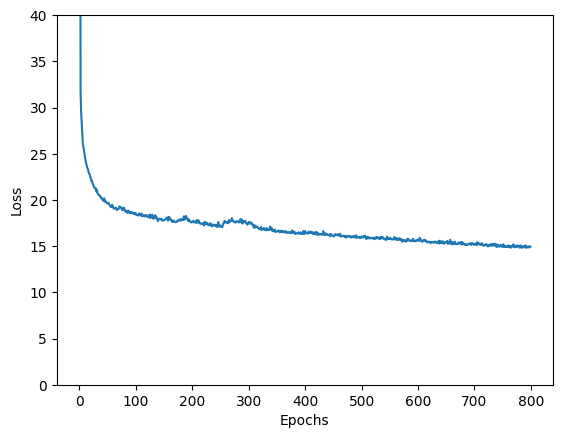

In [29]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim(0, 40)

We can now save, and load, the trained model for use.

In [21]:
torch.save(model.state_dict(), "../artefacts/model.pth")

In [22]:
model = models.SlangRNN(config)
model.load_state_dict(torch.load("../artefacts/model.pth"))

<All keys matched successfully>

We can now give a starting letter, eg 'a', and give the model a sequence of start_token and start_letter.
The model will now start to predict next tokens, until it predicts the stop_token.

In [39]:
start_letter = 'a'
max_length = 20
temperature = 1.0
start_token_idx = tokenizer.encode("<s>").ids[0]
start_letter_idx = tokenizer.encode(start_letter).ids[0]
input_seq = torch.tensor([[start_token_idx, start_letter_idx]], dtype=torch.long)

generated_word = [start_letter_idx]
hidden = model.init_hidden(input_seq)
for _ in range(max_length - 1):
    with torch.no_grad():
        output, hidden = model(input_seq, hidden)
    output = output.squeeze(0)
    output = output[-1, :].view(-1).div(temperature).exp()
    next_token = torch.multinomial(output, 1).item()
    if next_token == tokenizer.token_to_id("<pad>"):
        break
    generated_word.append(next_token)
    input_seq = torch.tensor([generated_word], dtype=torch.long)

This generates tokens

In [40]:
generated_word

[16, 24, 22, 23, 35, 46, 2]

Which we can decode into a word

In [41]:
tokenizer.decode(generated_word)

'aighten'

We can loop this process to generate multiple words.

In [44]:
models.sample_n(processed_words, n=10, model=model, tokenizer=tokenizer, max_length=20, temperature=1.0)

['x',
 'krum',
 'uu',
 'we7nes',
 'zai',
 "o'toe",
 'don',
 'ey',
 'ulangen-ven',
 'ummaal boers']

And save everything for later use.

In [29]:
tokenizer.save("../artefacts/tokenizer.json")

In [30]:
torch.save(model, "../artefacts/model.pth")